In [1]:
import torch 
import torch.nn as nn
import scripts.models as models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import scripts.utils as utils
import scripts.preprocessing as preprocessing
import os
import torchvision
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set common properties for a scientific paper with two-column format
plt.rcParams.update({
    'font.size': 8,              # Global font size
    'axes.titlesize': 10,        # Title font size
    'axes.labelsize': 8,         # Axes labels font size
    'xtick.labelsize': 8,        # X-tick labels font size
    'ytick.labelsize': 8,        # Y-tick labels font size
    'legend.fontsize': 8,        # Legend font size
    'figure.titlesize': 10,      # Figure title font size
    'lines.linewidth': 1.0,      # Line width
    'axes.linewidth': 0.8,       # Axes border width
    'xtick.major.width': 0.8,    # Major tick width
    'ytick.major.width': 0.8,    # Major tick width
    'xtick.minor.width': 0.6,    # Minor tick width
    'ytick.minor.width': 0.6,    # Minor tick width
    'xtick.major.size': 3,       # Major tick size
    'ytick.major.size': 3,       # Major tick size
    'xtick.minor.size': 2,       # Minor tick size
    'ytick.minor.size': 2,       # Minor tick size
    'legend.loc': 'best',        # Legend location
    'savefig.dpi': 300,          # Save figure resolution
    'figure.figsize': [7.5, 3.5] # Figure size in inches (adjust as needed)
})


In [ ]:
#import the models 

#CNN_model = model.load_state_dict(state_dict)   # Lo facciamo con 50 o con 10???
#color_model = model.load_state_dict(torch.load('final_models/CNN_color.pth'))
#jigsaw_model = model.load_state_dict(torch.load('final_models/CNN_jigsaw.pth'))


device = utils.use_GPU()

model = models.StormModel()
state_dict = torch.load('final_models/model_50_clean.pth')


incompatible_keys = model.load_state_dict(state_dict, strict=False)

print("Missing keys:", incompatible_keys.missing_keys)
print("Unexpected keys:", incompatible_keys.unexpected_keys)

model.to(device);

CUDA is available!  Training on GPU ...
cuda:0
Missing keys: []
Unexpected keys: []


In [ ]:
#Apply transformations to the images 
transform = transforms.Compose([
    # resize 
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224),
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean= [0.6388, 0.5445, 0.4448],  std =  [0.2713, 0.2864, 0.3131]),
])

# set the num_worker for the dataloader
num_workers = 4

#set the starting directory
im_dir = '.'

testset = torchvision.datasets.ImageFolder(root=os.path.join(im_dir,'data/test'), transform=transform)
plotset = torchvision.datasets.ImageFolder(root=os.path.join(im_dir,'data/test'), transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])
)

#create data loader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)
plotloader = torch.utils.data.DataLoader(plotset, batch_size=1, shuffle=False, num_workers=num_workers)


In [ ]:
# evaluate the model on the test set and print some statistics like recall and precision and confusion matrix

predictions = utils.get_all_predictions(model, testloader)
predicted_labels = predictions.argmax(dim=1)



In [ ]:
classes = testset.classes

In [ ]:
# get the true labels
true_labels = torch.tensor([label for image, label in testset])


In [ ]:
accuracy = torch.sum(true_labels == predicted_labels)/len(testset)
accuracy

tensor(0.3784)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels.cpu().numpy(), predicted_labels.cpu().numpy())

In [ ]:
# plot the number of elements in each class


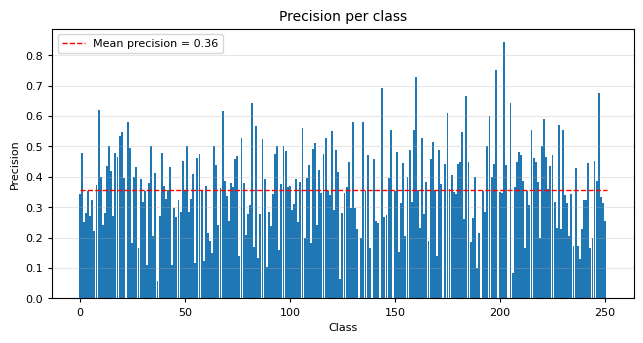

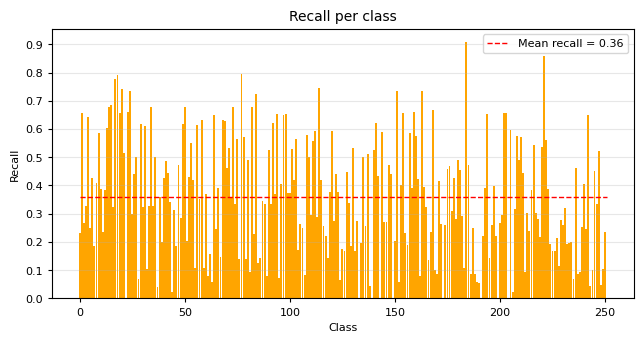

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Compute precision and recall for each class
precision = precision_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average=None, zero_division=0)
recall = recall_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average=None, zero_division=0)

mean_precision = np.mean(precision)
mean_recall = np.mean(recall)

# plot the results for precision
fig = plt.figure()
plt.bar(range(len(precision)),precision, width=0.9)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per class')
plt.grid(axis="y",alpha=0.3)
plt.hlines(mean_precision, 0, len(precision), colors='r', linestyles='dashed', label=f'Mean precision = {mean_precision:.2f}')
plt.legend()
plt.show()


fig.savefig('../figures_report/precision.jpg')

# plot the results for recall
fig = plt.figure()
plt.bar(np.arange(len(recall)),recall, width=0.9, color='orange')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per class')
plt.grid(axis="y",alpha=0.3)
plt.hlines(mean_recall, 0, len(recall), colors='r', linestyles='dashed', label=f'Mean recall = {mean_recall:.2f}')
plt.legend()
plt.show()

fig.savefig('../figures_report/recall.jpg')


In [ ]:
# print classes with 0 precision
zero_precision = np.where(precision == 0)[0]
print("Classes with 0 precision:")
for i in zero_precision:
    print(classes[i]) 

print()

sorted_precision = np.argsort(precision)

# rempve the classes with 0 precision
sorted_precision_no_zeros = sorted_precision[precision[sorted_precision] != 0]

top_5_precision = sorted_precision[-5:]

bottom_5_precision = sorted_precision_no_zeros[:5]

#reorder top_5 precision
top_5_precision = top_5_precision[::-1]

# write the name of the classes and tjeor precision
print("Top 5 precision classes")
for i in top_5_precision:
    print(classes[i], precision[i])
print()
print("Bottom 5 precision classes")
for i in bottom_5_precision:
    print(classes[i], precision[i])



Classes with 0 precision:
blancmange
limpet_food
lutefisk
marble_cake
mostaccioli
poi
rugulah
scallop
scrapple

Top 5 precision classes
scotch_egg 0.8444444444444444
savarin 0.75
pancake 0.7297297297297297
matzo_ball 0.6923076923076923
waffle 0.6764705882352942

Bottom 5 precision classes
casserole 0.05714285714285714
huitre 0.0625
shirred_egg 0.08333333333333333
rock_cake 0.1
farfalle 0.10344827586206896


In [ ]:
#chek for the top 5 precision classes the recall
print("Recall for the top 5 precision classes")
for i in top_5_precision:
    print(classes[i], recall[i])
    

Recall for the top 5 precision classes
scotch_egg 0.6551724137931034
savarin 0.21951219512195122
pancake 0.574468085106383
matzo_ball 0.5901639344262295
waffle 0.5227272727272727


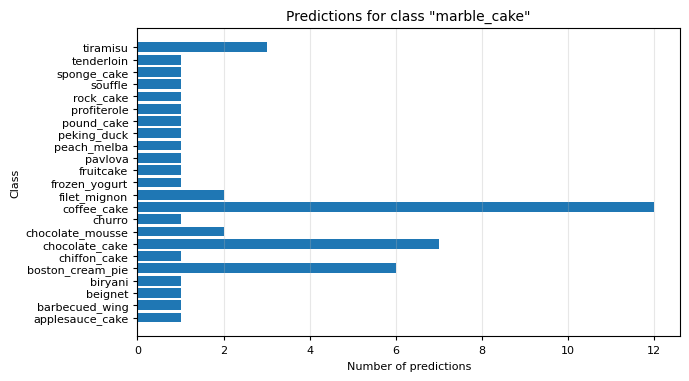

In [ ]:
# Consider the class with 0 precison and plot for the first one the classes that are predicted instead of it
# get the index of the class with 0 precision
index = zero_precision[3]
import seaborn as sns
# detect the line in the confusion matrix
line = cm[index]

#save the classes with a value higher than zero
predicted_classes = np.where(line > 0)[0]
sns.color_palette('Set2')
#plot it 
fig = plt.figure(figsize=(7,4))
plt.barh(np.arange(len(predicted_classes)), line[predicted_classes])
plt.yticks(np.arange(len(predicted_classes)), [classes[i] for i in predicted_classes])
plt.xlabel('Number of predictions')
plt.ylabel('Class')
plt.title(f'Predictions for class \"{classes[index]}\"')
plt.grid(axis="x",alpha=0.3)
plt.show()

fig.savefig(f'../figures_report/predictions_{classes[index]}.jpg')


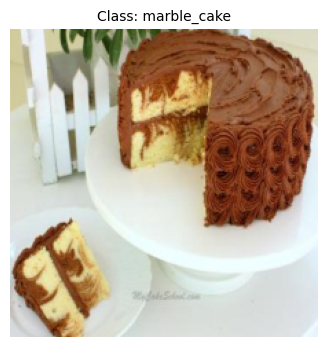

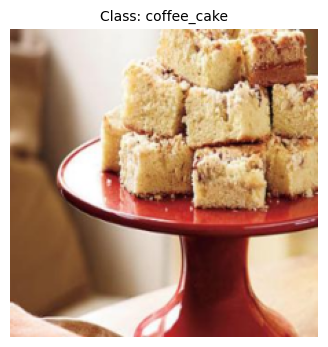

In [ ]:
# plot a image of th class "index" from the test set and one from the ones that are predicted instead of it

max_pred = np.argmax(line)

# get the first image of the class "index"
for i, (image, label) in enumerate(plotloader):
    if label == index:
        break

image = image.squeeze().permute(1, 2, 0).numpy()

fig = plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('off')
plt.title(f'Class: {classes[index]}')
plt.show()

fig.savefig(f'../figures_report/images_{classes[index]}.jpg')

# get image for the most predicted class
for i, (image, label) in enumerate(plotloader):
    if label == max_pred:
        break

image = image.squeeze().permute(1, 2, 0).numpy()

fig = plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('off')
plt.title(f'Class: {classes[max_pred]}')
plt.show()

fig.savefig(f'../figures_report/images_{classes[index]}_{classes[max_pred]}.jpg')


In [ ]:
# create a confusion matrix plot for the top 5 classes with the highest precision

In [ ]:
# Do a plot of the sorted classes by precision
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(sorted_classes, sorted_precision)
# dont show the x labels
plt.xticks([])
plt.xlabel('Classes (names omitted)')
plt.ylabel('Precision')
plt.title('Precision of each class')
plt.grid(axis='y')
plt.show()

NameError: name 'sorted_classes' is not defined

<Figure size 2000x500 with 0 Axes>